# Lab 4-2: Quantile Regression

## Why quantile regression?
What if we think that the rank order of values is basically the same in two datasets, but we don’t know if they’re linearly related. We can use a quantile regression to model a relationship between two variables without needing to assume anything about the function of that relationship (linear, or otherwise).

---

In this example we're again considering [SWE](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/null/?cid=nrcseprd1314833) measurements from two sites in California's Sierra Nevada, and want to evaluate the question:

**Quantile regression**: Could we use SWE measurements at Slide Canyon to predict SWE at Blue Canyon?

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# we will aslo need this 1d interpolation function
from scipy.interpolate import interp1d

In [2]:
# Read in a .csv file
data = pd.read_csv('pillows_example.csv')
data.tail()

,years,BLC_max,SLI_max
21,2006,761,1692
22,2007,99,597
23,2008,926,899
24,2009,439,935
25,2010,553,1023


Plot SWE for both sites to take a look at the data

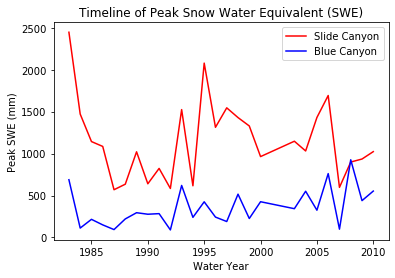

In [3]:
fig, ax = plt.subplots()

data.plot(x='years', y='SLI_max', c='r', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='b', ax=ax, label='Blue Canyon')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)')
ax.set_xlabel('Water Year')
ax.set_ylabel('Peak SWE (mm)');
plt.legend(loc="best")

### Steps to create a quantile regression model:

**1)** For each of your two datasets, create an empirical CDF

We can do this with a custom function like the `cunnane_quantile_array()` function below, which gives us quantile values given an array of numbers.

However, in this case, we want to be able to "look up" any quantile value (even those that lie between data points). For this, we can use `scipy.stats.mstats.mquantiles()` instead.

Review the documentation for [scipy.stats.mstats.mquantiles](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html), recall that the default options give us the Cunnane plotting position. Note how the function handles quantiles as they approach 0 or 1 at the lowest and highest end of our values. How many (quantile) values should we use in the input to this function to create an empirical CDF?

In [4]:
# This function should be able to accept any one-dimensional numpy array or list, of numbers
# It returns two numpy arrays, one of the sorted numbers, the other of the plotting position
def cunnane_quantile_array(numbers):
    '''This function also computes the Cunnane plotting position given an array or list of numbers (rather than a pandas dataframe).
    It has two outputs, first the sorted numbers, second the Cunnane plotting position for each of those numbers.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # 1) sort the data, using the numpy sort function (np.sort())
    sorted_numbers = np.sort(numbers)
    
    # length of the list of numbers
    n = len(sorted_numbers) 
    
    # make an empty array, of the same length. below we will add the plotting position values to this array
    cunnane_plotting_position = np.empty(n)
    
    # 2) compute the Cunnane plotting position for each number, using a for loop and the enumerate function
    for rank, number in enumerate(sorted_numbers):
        cunnane_plotting_position[rank] = ( (rank+1) - (2/5) ) / ( n + (1/5) )
    
    return sorted_numbers, cunnane_plotting_position

We can create both types of quantile plots and look at them together. When building the quantile regression model, we'll use both.

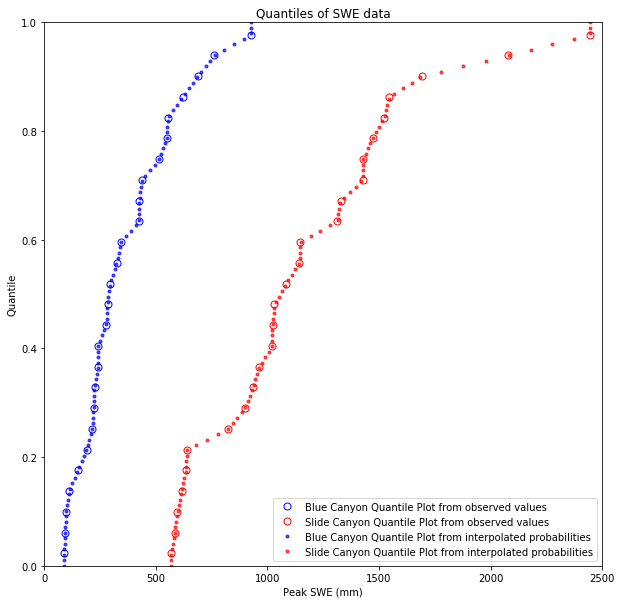

In [5]:
plt.figure(figsize=(10,10))

# Here we use the actual values from the dataset to create the plots
BLC_ordered, BLC_quantile = cunnane_quantile_array(data['BLC_max'])
SLI_ordered, SLI_quantile = cunnane_quantile_array(data['SLI_max'])
plt.plot(BLC_ordered, BLC_quantile, 'o', markeredgecolor='b', markerfacecolor='None', markersize=7, label='Blue Canyon Quantile Plot from observed values')
plt.plot(SLI_ordered, SLI_quantile, 'o', markeredgecolor='r', markerfacecolor='None', markersize=7, label='Slide Canyon Quantile Plot from observed values')


# We can also create these by picking arbitrary quantile values, then using the scipy.stats.mstats.mquantiles function
quantiles = np.linspace(0,1,100) # 100 quantile values linearly spaced between 0 and 1
plt.plot(stats.mstats.mquantiles(data['BLC_max'], quantiles), quantiles, 
         'b.', label='Blue Canyon Quantile Plot from interpolated probabilities', alpha=0.7)
plt.plot(stats.mstats.mquantiles(data['SLI_max'], quantiles), quantiles, 
         'r.', label='Slide Canyon Quantile Plot from interpolated probabilities', alpha=0.7)

plt.ylabel('Quantile')
plt.xlabel('Peak SWE (mm)')
plt.xlim((0,2500))
plt.ylim((0,1))
plt.title('Quantiles of SWE data')
plt.legend(loc="best");

**2)** Use the two empirical CDFs as a way of looking-up (or mapping) values from the predictor to the predictand, by matching which physical value corresponds to the same quantile.

The example below does this with one data point, where we start with a value of SWE at Slide Canyon, look up its quantile, then find the corresponding SWE value at Blue Canyon.

In [6]:
# This is our empirical cdf of the Slide Canyon data, which also includes values down to 0 and up to 1.
SLI_quantile = np.linspace(0,1,100)
SLI_ordered = stats.mstats.mquantiles(data['SLI_max'], SLI_quantile)

# When Slide Canyon has SWE equal to it's median, how much snow can we expect at Blue Canyon?
SLI_test = data['SLI_max'].median()

# Create a linear interpolation object based on these values (this lets us look up any value, x, and get back the y value)
f_SLI = interp1d(SLI_ordered, SLI_quantile)
SLI_test_quantile = f_SLI(SLI_test)

print('In the empirical Slide Canyon CDF, a value of {} mm SWE (the median) corresponds to a quantile of {}'.format(SLI_test, np.round(SLI_test_quantile,2)))

In the empirical Slide Canyon CDF, a value of 1058.0 mm SWE (the median) corresponds to a quantile of 0.5


Visualize this in a plot

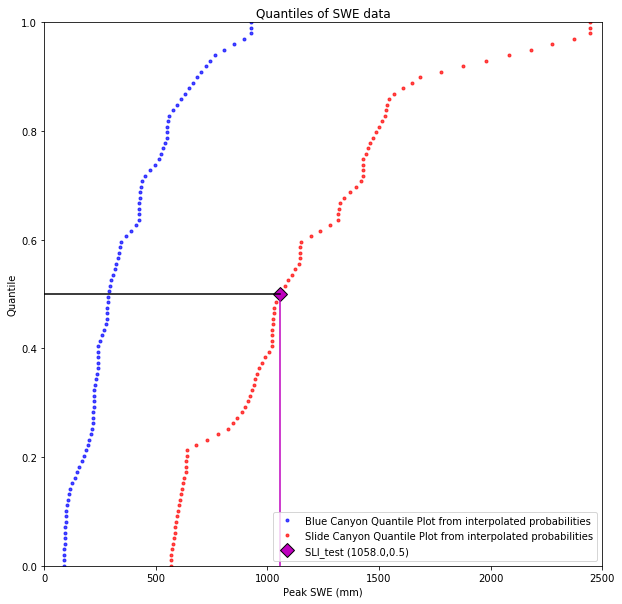

In [7]:
plt.figure(figsize=(10,10))

# We can also create these by picking arbitrary quantile values, then using the scipy.stats.mstats.mquantiles function
quantiles = np.linspace(0,1,100) # 100 quantile values linearly spaced between 0 and 1
plt.plot(stats.mstats.mquantiles(data['BLC_max'], quantiles), quantiles, 
         'b.', label='Blue Canyon Quantile Plot from interpolated probabilities', alpha=0.7)
plt.plot(stats.mstats.mquantiles(data['SLI_max'], quantiles), quantiles, 
         'r.', label='Slide Canyon Quantile Plot from interpolated probabilities', alpha=0.7)

# Plot the test point value
plt.plot(SLI_test,SLI_test_quantile,'D', markerfacecolor='m', markeredgecolor='k',markersize=10, label='SLI_test ({},{})'.format(SLI_test, np.round(SLI_test_quantile,2)))
# Plot a line from the x-axis to the test point
plt.plot([SLI_test, SLI_test], [0, SLI_test_quantile], c='m', linestyle='-')
# Plot a line from the test point to the y-axis
plt.plot([0, SLI_test], [SLI_test_quantile, SLI_test_quantile], c='k', linestyle='-')

plt.ylabel('Quantile')
plt.xlabel('Peak SWE (mm)')
plt.xlim((0,2500))
plt.ylim((0,1))
plt.title('Quantiles of SWE data')
plt.legend(loc="best");

We see that our test value corresponds to the median value at Slide Canyon, quantile value 0.5. 

(Yes, you would hope so, since I defined it as the median to begin with, but it's always best practice to start coding with a situation where you know the right answer.)

Now, we need to take this Slide Canyon quantile value (0.5) and find the Blue Canyon SWE value that corresponds to its same quantile value (finding the Blue Canyon median in this case).

We first need to create an interpolation object that lets us translate from Blue Canyon quantile values to Blue Canyon SWE values:

In [8]:
# This is our empirical cdf of the Blue Canyon data, which also includes values down to 0 and up to 1.
BLC_quantile = np.linspace(0,1,100)
BLC_ordered = stats.mstats.mquantiles(data['BLC_max'], BLC_quantile)

# Create a linear interpolation object based on these values (this lets us look up any value, y, and get back the x value) 
# *note we've reversed the order of quantiles and SWE compared the the first interpolation object we created
g_BLC = interp1d(BLC_quantile, BLC_ordered)

# So if we look up a quantile value in our function g_BLC()
BLC_test = g_BLC(SLI_test_quantile)

print('In the empirical Blue Canyon CDF, a quantile of {} corresponds to a SWE value of {} mm SWE (the median)'.format(np.round(SLI_test_quantile,2), BLC_test))

In the empirical Blue Canyon CDF, a quantile of 0.5 corresponds to a SWE value of 289.5 mm SWE (the median)


Visualize the complete problem:

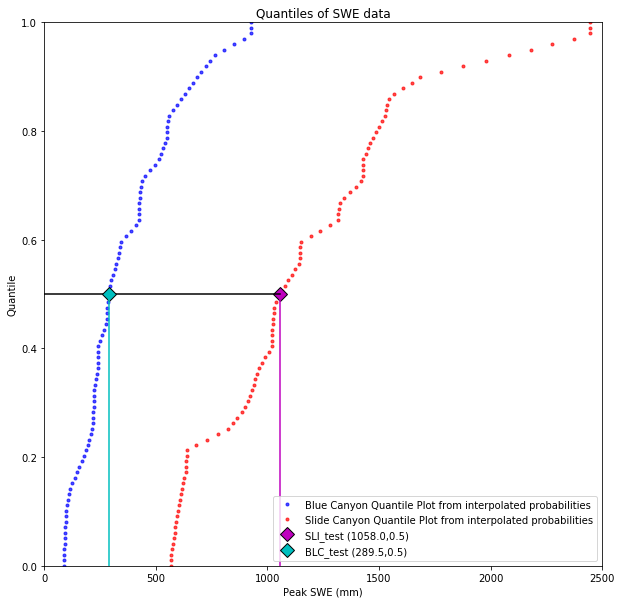

In [9]:
plt.figure(figsize=(10,10))

# We can also create these by picking arbitrary quantile values, then using the scipy.stats.mstats.mquantiles function
quantiles = np.linspace(0,1,100) # 100 quantile values linearly spaced between 0 and 1
plt.plot(stats.mstats.mquantiles(data['BLC_max'], quantiles), quantiles, 
         'b.', label='Blue Canyon Quantile Plot from interpolated probabilities', alpha=0.7)
plt.plot(stats.mstats.mquantiles(data['SLI_max'], quantiles), quantiles, 
         'r.', label='Slide Canyon Quantile Plot from interpolated probabilities', alpha=0.7)

# Plot the Slide Canyon test point value
plt.plot(SLI_test,SLI_test_quantile,'D', markerfacecolor='m', markeredgecolor='k',markersize=10, label='SLI_test ({},{})'.format(SLI_test, np.round(SLI_test_quantile,2)))
# Plot a line from the x-axis to the test point
plt.plot([SLI_test, SLI_test], [0, SLI_test_quantile], c='m', linestyle='-')
# Plot a line from the test point to the y-axis
plt.plot([0, SLI_test], [SLI_test_quantile, SLI_test_quantile], c='k', linestyle='-')

# Plot the Blue Canyon test point value
plt.plot(BLC_test,SLI_test_quantile,'D', markerfacecolor='c', markeredgecolor='k',markersize=10, label='BLC_test ({},{})'.format(BLC_test, np.round(SLI_test_quantile,2)))
# Plot a line from the test point to the x-axis
plt.plot([BLC_test, BLC_test], [0, SLI_test_quantile], c='c', linestyle='-')

plt.ylabel('Quantile')
plt.xlabel('Peak SWE (mm)')
plt.xlim((0,2500))
plt.ylim((0,1))
plt.title('Quantiles of SWE data')
plt.legend(loc="best");

---

Now that we've walked through a single-point example, we can apply these steps efficiently to the whole dataset, starting from the beginning:

1) Create empirical CDFs for both data sets

In [10]:
quantiles = np.linspace(0,1,100)

# This is our empirical cdf of the Slide Canyon data, which also includes values down to 0 and up to 1.
SLI_ordered = stats.mstats.mquantiles(data['SLI_max'], quantiles)

# This is our empirical cdf of the Blue Canyon data, which also includes values down to 0 and up to 1.
BLC_ordered = stats.mstats.mquantiles(data['BLC_max'], quantiles)

2) Use the CDFs to "look up" SWE from Slide Canyon to predict SWE in Blue Canyon

In [11]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_SLI = interp1d(SLI_ordered, quantiles)
# Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_BLC = interp1d(quantiles, BLC_ordered)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
BLC_predicted=g_BLC( f_SLI( data['SLI_max'] ) )

Plot the results:

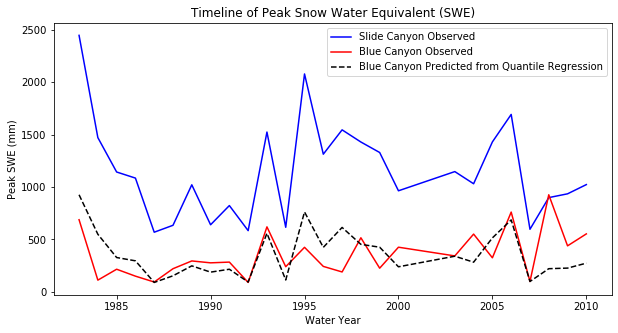

In [12]:
# And we can see how well this did by making a time series plot of our actual and predicted values
# Original data:
plt.figure(figsize=(10,5))
plt.plot(data['years'],data['SLI_max'],'b-', label='Slide Canyon Observed');
plt.plot(data['years'],data['BLC_max'],'r-', label='Blue Canyon Observed');

# Predicted with linear regression between Slide Canyon and Blue Canyon
plt.plot(data['years'],BLC_predicted,'k--', label='Blue Canyon Predicted from Quantile Regression')
plt.legend()
plt.title('Timeline of Peak Snow Water Equivalent (SWE)')
plt.xlabel('Water Year')
plt.ylabel('Peak SWE (mm)');


Compare the results of the quantile regression with the results of the linear regression in the previous lab.

Which do you think is the best approach here and why?

#### Why you should not do statistics in the absense of physically-based science (from Professor Jessica Lundquist)
What you see above is that the quantile mapping forces the rank order of the predicted timeseries to match the rank order of the prectictor time series.  In this particular case, that isn't always the best idea.  Blue Canyon is at a much lower elevation, and in warmer winters, Blue Canyon will get rain at times when Slide Canyon gets snow.  In those years, any attempt at correlation falls apart.  Thus, we would want to add a predictor variable that had something about temperature or rain vs snow (which hasn't yet been provided in these examples).